# Gameday Model for SPX

In [1]:
import pandas as pd
import pandas_datareader as pdr
import numpy as np
import yfinance as yf
import json
import requests
from bs4 import BeautifulSoup
from typing import List
import xgboost as xgb
from tqdm import tqdm
from sklearn import linear_model, ensemble

# Helper Functions

In [2]:
def walk_forward_validation(df, target_column, num_training_rows, num_periods):
    
    # Create an XGBRegressor model
    # model = xgb.XGBRegressor(n_estimators=100, objective='reg:squarederror', random_state = 42)
    model = linear_model.LinearRegression()

    overall_results = []
    # Iterate over the rows in the DataFrame, one step at a time
    for i in tqdm(range(num_training_rows, df.shape[0] - num_periods + 1)):
        # Split the data into training and test sets
        X_train = df.drop(target_column, axis=1).iloc[:i]
        y_train = df[target_column].iloc[:i]
        X_test = df.drop(target_column, axis=1).iloc[i:i+num_periods]
        y_test = df[target_column].iloc[i:i+num_periods]
        
        # Fit the model to the training data
        model.fit(X_train, y_train)
        
        # Make a prediction on the test data
        predictions = model.predict(X_test)
        
        # Create a DataFrame to store the true and predicted values
        result_df = pd.DataFrame({'True': y_test, 'Predicted': predictions}, index=y_test.index)
        
        overall_results.append(result_df)

    df_results = pd.concat(overall_results)
    # model.save_model('model_lr.bin')
    # Return the true and predicted values, and fitted model
    return df_results, model

def walk_forward_validation_clf(df, target_column, num_training_rows, num_periods):
    
    # Create an XGBRegressor model
    model = xgb.XGBClassifier(n_estimators=10, random_state = 42)
    # model = linear_model.LogisticRegression(max_iter=2000)
    # model = ensemble.AdaBoostClassifier(n_estimators=10, random_state=42)

    
    overall_results = []
    # Iterate over the rows in the DataFrame, one step at a time
    for i in tqdm(range(num_training_rows, df.shape[0] - num_periods + 1)):
        # Split the data into training and test sets
        X_train = df.drop(target_column, axis=1).iloc[:i]
        y_train = df[target_column].iloc[:i]
        X_test = df.drop(target_column, axis=1).iloc[i:i+num_periods]
        y_test = df[target_column].iloc[i:i+num_periods]
        
        # Fit the model to the training data
        model.fit(X_train, y_train)
        
        # Make a prediction on the test data
        predictions = model.predict_proba(X_test)[:,-1]
        
        # Create a DataFrame to store the true and predicted values
        result_df = pd.DataFrame({'True': y_test, 'Predicted': predictions}, index=y_test.index)
        
        overall_results.append(result_df)

    df_results = pd.concat(overall_results)
    # model.save_model('model_clf_lr.bin')
    # Return the true and predicted values, and fitted model
    return df_results, model

def walk_forward_validation_clf2(df, target_column, num_training_rows, num_periods):
    
    # Create an XGBRegressor model
    model = xgb.XGBClassifier(n_estimators=100, random_state = 42)
    
    overall_results = []
    # Iterate over the rows in the DataFrame, one step at a time
    for i in tqdm(range(num_training_rows, df.shape[0] - num_periods + 1)):
        # Split the data into training and test sets
        X_train = df.drop(target_column, axis=1).iloc[:i]
        y_train = df[target_column].iloc[:i]
        X_test = df.drop(target_column, axis=1).iloc[i:i+num_periods]
        y_test = df[target_column].iloc[i:i+num_periods]
        
        # Fit the model to the training data
        model.fit(X_train, y_train)
        
        # Make a prediction on the test data
        predictions = model.predict_proba(X_test)[:,-1]
        
        # Create a DataFrame to store the true and predicted values
        result_df = pd.DataFrame({'True': y_test, 'Predicted': predictions}, index=y_test.index)
        
        overall_results.append(result_df)

    df_results = pd.concat(overall_results)
    model.save_model('model_ensemble.bin')
    # Return the true and predicted values, and fitted model
    return df_results, model

In [3]:
f = open('settings.json')
j = json.load(f)

API_KEY_FRED = j['API_KEY_FRED']

def parse_release_dates(release_id: str) -> List[str]:
    release_dates_url = f'https://api.stlouisfed.org/fred/release/dates?release_id={release_id}&realtime_start=2015-01-01&include_release_dates_with_no_data=true&api_key={API_KEY_FRED}'
    r = requests.get(release_dates_url)
    text = r.text
    soup = BeautifulSoup(text, 'xml')
    dates = []
    for release_date_tag in soup.find_all('release_date', {'release_id': release_id}):
        dates.append(release_date_tag.text)
    return dates

def parse_release_dates_obs(series_id: str) -> List[str]:
    obs_url = f'https://api.stlouisfed.org/fred/series/observations?series_id={series_id}&realtime_start=2015-01-01&include_release_dates_with_no_data=true&api_key={API_KEY_FRED}'
    r = requests.get(obs_url)
    text = r.text
    soup = BeautifulSoup(text, 'xml')
    observations  = []
    for observation_tag in soup.find_all('observation'):
        date = observation_tag.get('date')
        value = observation_tag.get('value')
        observations.append((date, value))
    return observations

econ_dfs = {}

econ_tickers = [
    'WALCL',
    'NFCI',
    'WRESBAL'
]

for et in tqdm(econ_tickers, desc='getting econ tickers'):
    # p = parse_release_dates_obs(et)
    # df = pd.DataFrame(columns = ['ds',et], data = p)
    df = pdr.get_data_fred(et)
    df.index = df.index.rename('ds')
    # df.index = pd.to_datetime(df.index.rename('ds')).dt.tz_localize(None)
    # df['ds'] = pd.to_datetime(df['ds']).dt.tz_localize(None)
    econ_dfs[et] = df

# walcl = pd.DataFrame(columns = ['ds','WALCL'], data = p)
# walcl['ds'] = pd.to_datetime(walcl['ds']).dt.tz_localize(None)

# nfci = pd.DataFrame(columns = ['ds','NFCI'], data = p2)
# nfci['ds'] = pd.to_datetime(nfci['ds']).dt.tz_localize(None)

release_ids = [
    "10", # "Consumer Price Index"
    "46", # "Producer Price Index"
    "50", # "Employment Situation"
    "53", # "Gross Domestic Product"
    "103", # "Discount Rate Meeting Minutes"
    "180", # "Unemployment Insurance Weekly Claims Report"
    "194", # "ADP National Employment Report"
    "323" # "Trimmed Mean PCE Inflation Rate"
]

release_names = [
    "CPI",
    "PPI",
    "NFP",
    "GDP",
    "FOMC",
    "UNEMP",
    "ADP",
    "PCE"
]

releases = {}

for rid, n in tqdm(zip(release_ids, release_names), total = len(release_ids), desc='Getting release dates'):
    releases[rid] = {}
    releases[rid]['dates'] = parse_release_dates(rid)
    releases[rid]['name'] = n 

# Create a DF that has all dates with the name of the col as 1
# Once merged on the main dataframe, days with econ events will be 1 or None. Fill NA with 0
# This column serves as the true/false indicator of whether there was economic data released that day.
for rid in tqdm(release_ids, desc='Making indicators'):
    releases[rid]['df'] = pd.DataFrame(
        index=releases[rid]['dates'],
        data={
        releases[rid]['name']: 1
        })
    releases[rid]['df'].index = pd.DatetimeIndex(releases[rid]['df'].index)
    # releases[rid]['df']['ds'] = pd.to_datetime(releases[rid]['df']['ds']).dt.tz_localize(None)
    # releases[rid]['df'] = releases[rid]['df'].set_index('ds')

Making indicators: 100%|██████████| 8/8 [00:00<00:00, 3996.48it/s]


# Data Gathering & Prep

In [4]:
vix = yf.Ticker('^VIX')
spx = yf.Ticker('^GSPC')

# prices_vix = vix.history(start='2018-07-01', interval='1d')
# prices_spx = spx.history(start='2018-07-01', interval='1d')
prices_vix = vix.history(start='2020-01-01', interval='1d')
prices_spx = spx.history(start='2020-01-01', interval='1d')

In [5]:
prices_spx['index'] = [str(x).split()[0] for x in prices_spx.index]
prices_spx['index'] = pd.to_datetime(prices_spx['index']).dt.date
prices_spx.index = prices_spx['index']
prices_spx = prices_spx.drop(columns='index')

prices_vix['index'] = [str(x).split()[0] for x in prices_vix.index]
prices_vix['index'] = pd.to_datetime(prices_vix['index']).dt.date
prices_vix.index = prices_vix['index']
prices_vix = prices_vix.drop(columns='index')

data = prices_spx.merge(prices_vix[['Open','High','Low','Close']], left_index=True, right_index=True, suffixes=['','_VIX'])
data.index = pd.DatetimeIndex(data.index)

## Feature Development

In [6]:
# Features
data['PrevClose'] = data['Close'].shift(1)
data['Perf5Day'] = data['Close'] > data['Close'].shift(5)
data['Perf5Day_n1'] = data['Perf5Day'].shift(1)
data['Perf5Day_n1'] = data['Perf5Day_n1'].astype(bool)
data['GreenDay'] = (data['Close'] > data['PrevClose']) * 1
data['RedDay'] = (data['Close'] <= data['PrevClose']) * 1

data['VIX5Day'] = data['Close_VIX'] > data['Close_VIX'].shift(5)
data['VIX5Day_n1'] = data['VIX5Day'].astype(bool)

data['Range'] = data[['Open','High']].max(axis=1) - data[['Low','Open']].min(axis=1) # Current day range in points
data['RangePct'] = data['Range'] / data['Close']
data['VIXLevel'] = pd.qcut(data['Close_VIX'], 4)
data['OHLC4_VIX'] = data[['Open_VIX','High_VIX','Low_VIX','Close_VIX']].mean(axis=1)
data['OHLC4'] = data[['Open','High','Low','Close']].mean(axis=1)
data['OHLC4_Trend'] = data['OHLC4'] > data['OHLC4'].shift(1)
data['OHLC4_Trend_n1'] = data['OHLC4_Trend'].shift(1)
data['OHLC4_Trend_n1'] = data['OHLC4_Trend_n1'].astype(float)
data['OHLC4_Trend_n2'] = data['OHLC4_Trend'].shift(1)
data['OHLC4_Trend_n2'] = data['OHLC4_Trend_n2'].astype(float)
data['RangePct_n1'] = data['RangePct'].shift(1)
data['RangePct_n2'] = data['RangePct'].shift(2)
data['OHLC4_VIX_n1'] = data['OHLC4_VIX'].shift(1)
data['OHLC4_VIX_n2'] = data['OHLC4_VIX'].shift(2)
data['CurrentGap'] = (data['Open'] - data['PrevClose']) / data['PrevClose']
data['CurrentGap'] = data['CurrentGap'].shift(-1)
data['DayOfWeek'] = pd.to_datetime(data.index)
data['DayOfWeek'] = data['DayOfWeek'].dt.day

# Target -- the next day's low
data['Target'] = (data['OHLC4'] / data['PrevClose']) - 1
data['Target'] = data['Target'].shift(-1)
# data['Target'] = data['RangePct'].shift(-1)

# Target for clf -- whether tomorrow will close above or below today's close
data['Target_clf'] = data['Close'] > data['PrevClose']
data['Target_clf'] = data['Target_clf'].shift(-1)
data['DayOfWeek'] = pd.to_datetime(data.index)
data['Quarter'] = data['DayOfWeek'].dt.quarter
data['DayOfWeek'] = data['DayOfWeek'].dt.weekday

for rid in tqdm(release_ids, desc='Merging econ data'):
    # Get the name of the release
    n = releases[rid]['name']
    # Merge the corresponding DF of the release
    data = data.merge(releases[rid]['df'], how = 'left', left_index=True, right_index=True)
    # Create a column that shifts the value in the merged column up by 1
    data[f'{n}_shift'] = data[n].shift(-1)
    # Fill the rest with zeroes
    data[n] = data[n].fillna(0)
    data[f'{n}_shift'] = data[f'{n}_shift'].fillna(0)
    
data['BigNewsDay'] = data[[x for x in data.columns if '_shift' in x]].max(axis=1)

Merging econ data: 100%|██████████| 8/8 [00:00<00:00, 1141.81it/s]


In [7]:
def cumul_sum(col):
    nums = []
    s = 0
    for x in col:
        if x == 1:
            s += 1
        elif x == 0:
            s = 0
        nums.append(s)
    return nums

consec_green = cumul_sum(data['GreenDay'].values)
consec_red = cumul_sum(data['RedDay'].values)

data['DaysGreen'] = consec_green
data['DaysRed'] = consec_red

In [8]:
max(consec_red)

7

In [9]:
data[['GreenDay','DaysGreen']]

,GreenDay,DaysGreen
index,,
2020-01-02,0,0
2020-01-03,0,0
2020-01-06,1,1
2020-01-07,0,0
2020-01-08,1,1
...,...,...
2023-07-10,1,1
2023-07-11,1,2
2023-07-12,1,3


## Model Data

In [10]:
final_row = data.index[-2]

In [11]:
final_row

Timestamp('2023-07-13 00:00:00')

In [12]:
df_final = data.loc[:final_row,
[
    'BigNewsDay',
    'Quarter',
    'Perf5Day',
    'Perf5Day_n1',
    'DaysGreen',
    'DaysRed',
    # 'OHLC4_Trend',
    # 'OHLC4_Trend_n1',
    # 'OHLC4_Trend_n2',
    # 'VIX5Day',
    # 'VIX5Day_n1',
    'CurrentGap',
    'RangePct',
    'RangePct_n1',
    'RangePct_n2',
    'OHLC4_VIX',
    'OHLC4_VIX_n1',
    'OHLC4_VIX_n2',
    'Target',
    'Target_clf'
    ]]
df_final = df_final.dropna(subset=['Target','Target_clf','Perf5Day_n1'])

In [13]:
df_final.drop(columns=['Target_clf']).dtypes

BigNewsDay      float64
Quarter           int64
Perf5Day           bool
Perf5Day_n1        bool
DaysGreen         int64
DaysRed           int64
CurrentGap      float64
RangePct        float64
RangePct_n1     float64
RangePct_n2     float64
OHLC4_VIX       float64
OHLC4_VIX_n1    float64
OHLC4_VIX_n2    float64
Target          float64
dtype: object

# Regression Model

In [14]:
df_final.drop(columns=['Target_clf']).isnull().sum()

BigNewsDay      0
Quarter         0
Perf5Day        0
Perf5Day_n1     0
DaysGreen       0
DaysRed         0
CurrentGap      0
RangePct        0
RangePct_n1     1
RangePct_n2     2
OHLC4_VIX       0
OHLC4_VIX_n1    1
OHLC4_VIX_n2    2
Target          0
dtype: int64

In [15]:
df_final

,BigNewsDay,Quarter,Perf5Day,Perf5Day_n1,DaysGreen,DaysRed,CurrentGap,RangePct,RangePct_n1,RangePct_n2,OHLC4_VIX,OHLC4_VIX_n1,OHLC4_VIX_n2,Target,Target_clf
index,,,,,,,,,,,,,,,
2020-01-02,0.0,1,False,True,0,0,-0.009666,0.006940,NaN,NaN,13.0175,NaN,NaN,-0.007804,False
2020-01-03,0.0,1,False,False,0,1,-0.005348,0.007360,0.006940,NaN,14.5900,13.0175,NaN,-0.001089,False
2020-01-06,0.0,1,False,False,1,0,-0.001362,0.009919,0.007360,0.006940,14.8075,14.5900,13.0175,-0.002213,False
2020-01-07,1.0,1,False,False,0,1,0.000436,0.003855,0.009919,0.007360,13.8700,14.8075,14.5900,0.003603,True
2020-01-08,1.0,1,False,False,1,0,0.003990,0.009345,0.003855,0.009919,14.1700,13.8700,14.8075,0.005209,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-07,0.0,3,True,True,0,3,-0.001073,0.009773,0.008516,0.003924,15.2975,15.5400,14.2900,0.000596,True
2023-07-10,0.0,3,False,True,1,0,0.001365,0.005143,0.009773,0.008516,15.6000,15.2975,15.5400,0.003900,True
2023-07-11,1.0,3,False,False,2,0,0.006404,0.007925,0.005143,0.009773,14.9350,15.6000,15.2975,0.007568,True


In [16]:
res, xgbr = walk_forward_validation(df_final.drop(columns=['Target_clf']).dropna(), 'Target', 100, 1)

100%|██████████| 786/786 [00:01<00:00, 427.89it/s]


In [17]:
res

,True,Predicted
index,,
2020-05-29,0.000902,-0.004820
2020-06-01,0.004532,0.002347
2020-06-02,0.010414,0.006996
2020-06-03,-0.003863,-0.004339
2020-06-04,0.022807,0.022731
...,...,...
2023-07-07,0.000596,-0.001092
2023-07-10,0.003900,0.001262
2023-07-11,0.007568,0.008085


In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=res['True'],
                   y_pred=res['Predicted'])

242.3313369042058

In [19]:
mean_absolute_error(y_true=res['True'],
                   y_pred=res['Predicted']) * 100

0.36843160242157397

<AxesSubplot:xlabel='index'>

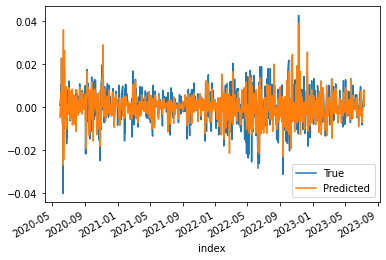

In [20]:
res.plot()

In [21]:
# import matplotlib.pyplot as plt
# fig, ax = plt.subplots(figsize=(10, 8))
# xgb.plot_importance(xgbr, importance_type='weight', ax=ax)

In [22]:
np.mean(data['CurrentGap'].abs()>0.0015)

0.6962879640044994

In [23]:
df_compare_reg = df_final.drop(columns=['Target','Target_clf']).merge(res, left_index=True, right_index=True)
df_compare_reg = df_compare_reg.merge(data[['PrevClose','High','Low','Close']], left_index=True, right_index=True)

In [24]:
# How often was the predicted OHLC4 within the current day's range?
df_compare_reg['PredOHLC4'] = df_compare_reg['Predicted'].shift(1)
df_compare_reg['PredOHLC4'] = (1 + df_compare_reg['PredOHLC4']) * df_compare_reg['PrevClose']

In [25]:
df_compare_reg['InRange'] = (df_compare_reg['PredOHLC4'] <= df_compare_reg['High']) & (df_compare_reg['PredOHLC4'] >= df_compare_reg['Low'])

In [26]:
df_compare_reg['InRange'].mean()

0.9083969465648855

In [27]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, PrecisionRecallDisplay

# When the predicted OHLC4 was positive, how often was it a green day?
df_compare_reg['PredDirection'] = df_compare_reg['Predicted'] > 0
# df_compare_reg['PredDirection'] = df_compare_reg['PredDirection'].shift(1)
df_compare_reg['ActualDirection'] = df_compare_reg['Close'] > df_compare_reg['PrevClose']
df_compare_reg['ActualDirection'] = df_compare_reg['ActualDirection'].shift(-1)

In [28]:
df_compare_reg.pivot_table(columns='PredDirection', index='ActualDirection', values='Close', aggfunc='count')

PredDirection,False,True
ActualDirection,,
False,259,114
True,116,296


In [29]:
compare_ohlc4_model = df_compare_reg.dropna(subset=['PredDirection','ActualDirection'])
print(roc_auc_score(compare_ohlc4_model['ActualDirection'].astype(int), compare_ohlc4_model['PredDirection'].astype(int)))
print(precision_score(compare_ohlc4_model['ActualDirection'].astype(int), compare_ohlc4_model['PredDirection'].astype(int)))
print(recall_score(compare_ohlc4_model['ActualDirection'].astype(int), compare_ohlc4_model['PredDirection'].astype(int)))

0.7064082875660481
0.7219512195121951
0.7184466019417476


# Classification Model

In [30]:
df_final.drop(columns=['Target']).isnull().sum()

BigNewsDay      0
Quarter         0
Perf5Day        0
Perf5Day_n1     0
DaysGreen       0
DaysRed         0
CurrentGap      0
RangePct        0
RangePct_n1     1
RangePct_n2     2
OHLC4_VIX       0
OHLC4_VIX_n1    1
OHLC4_VIX_n2    2
Target_clf      0
dtype: int64

In [31]:
df_final['Target_clf'] = df_final['Target_clf'].astype(bool)

In [32]:
res1, xgbc = walk_forward_validation_clf(df_final.drop(columns=['Target']).dropna(), 'Target_clf', 100, 1)

100%|██████████| 786/786 [00:07<00:00, 99.86it/s] 


In [33]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, PrecisionRecallDisplay
print(roc_auc_score(res1['True'].astype(int), res1['Predicted'].values))
print(precision_score(res1['True'].astype(int), res1['Predicted'] > 0.5))
print(recall_score(res1['True'].astype(int), res1['Predicted'] > 0.5))
# print(roc_auc_score(res1['True'].astype(int), res1['Predicted'].values))

0.8259306370385754
0.7524271844660194
0.7524271844660194


In [34]:
res1['True'].mean()

0.5241730279898219

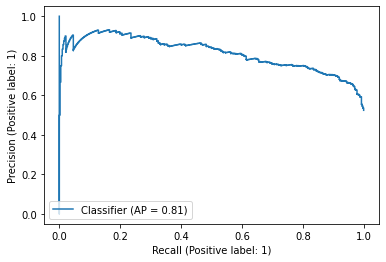

In [35]:
PrecisionRecallDisplay.from_predictions(res1['True'].astype(int), res1['Predicted'].values)

In [36]:
# import matplotlib.pyplot as plt
# fig, ax = plt.subplots(figsize=(10, 8))
# xgb.plot_importance(xgbc, importance_type='gain', ax=ax)

In [37]:
df_compare = df_final.drop(columns=['Target','Target_clf']).merge(res1, left_index=True, right_index=True)

# What do these false positives look like?
# false_pos = df_compare.loc[(df_compare['True'] == False) & (df_compare['Predicted'] > 0.5)]

In [38]:
# Label fp, tp, fn, tn
def label_type(actual, pred):
    if actual == True and pred > 0.5:
        return 'TP'
    elif actual == False and pred > 0.5:
        return 'FP'
    elif actual == False and pred <= 0.5:
        return 'TN'
    elif actual == True and pred <= 0.5:
        return 'FN'

df_compare['label_type'] = [label_type(actual, pred) for actual, pred in zip(df_compare['True'],df_compare['Predicted'])]

In [39]:
df_compare.groupby('label_type')['True'].count()

label_type
FN    102
FP    102
TN    272
TP    310
Name: True, dtype: int64

In [40]:
302 / (302 + 109)

0.7347931873479319

In [41]:
266 / (266 + 107)

0.7131367292225201

In [42]:
df_compare_clf = df_final.drop(columns=['Target','Target_clf']).merge(res1, left_index=True, right_index=True)
df_compare_clf = df_compare_clf.merge(data[['PrevClose','High','Low','Close']], left_index=True, right_index=True)

# When the predicted OHLC4 was positive, how often was it a green day?
df_compare_clf['PredDirection'] = df_compare_clf['Predicted'] > 0.5
# df_compare_reg['PredDirection'] = df_compare_reg['PredDirection'].shift(1)
df_compare_clf['ActualDirection'] = df_compare_clf['Close'] > df_compare_clf['PrevClose']
df_compare_clf['ActualDirection'] = df_compare_clf['ActualDirection'].shift(-1)

In [43]:
df_compare_clf

,BigNewsDay,Quarter,Perf5Day,Perf5Day_n1,DaysGreen,DaysRed,CurrentGap,RangePct,RangePct_n1,RangePct_n2,...,OHLC4_VIX_n1,OHLC4_VIX_n2,True,Predicted,PrevClose,High,Low,Close,PredDirection,ActualDirection
index,,,,,,,,,,,,,,,,,,,,,
2020-05-29,0.0,2,True,True,1,0,-0.001817,0.016608,0.014942,0.021903,...,28.4325,27.922501,True,0.040308,3029.729980,3049.169922,2998.610107,3044.310059,False,True
2020-06-01,0.0,2,True,True,2,0,0.002962,0.010027,0.016608,0.014942,...,28.5650,28.432500,True,0.815024,3044.310059,3062.179932,3031.540039,3055.729980,True,True
2020-06-02,1.0,2,True,True,3,0,0.005869,0.009553,0.010027,0.016608,...,28.9700,28.565000,True,0.895856,3055.729980,3081.070068,3051.639893,3080.820068,True,True
2020-06-03,1.0,2,True,True,4,0,-0.003622,0.010260,0.009553,0.010027,...,27.6050,28.970000,False,0.111962,3080.820068,3130.939941,3098.899902,3122.870117,False,False
2020-06-04,1.0,2,True,True,0,1,0.016544,0.012370,0.010260,0.009553,...,26.1075,27.605000,True,0.928517,3122.870117,3128.909912,3090.409912,3112.350098,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-07,0.0,3,True,True,0,3,-0.001073,0.009773,0.008516,0.003924,...,15.5400,14.290000,True,0.113828,4411.589844,4440.390137,4397.399902,4398.950195,False,True
2023-07-10,0.0,3,False,True,1,0,0.001365,0.005143,0.009773,0.008516,...,15.2975,15.540000,True,0.903845,4398.950195,4412.600098,4389.919922,4409.529785,True,True
2023-07-11,1.0,3,False,False,2,0,0.006404,0.007925,0.005143,0.009773,...,15.6000,15.297500,True,0.868886,4409.529785,4443.640137,4408.459961,4439.259766,True,True


In [44]:
df_compare_clf.pivot_table(columns='PredDirection', index='ActualDirection', values='Close', aggfunc='count')

PredDirection,False,True
ActualDirection,,
False,242,131
True,132,280


In [45]:
276 / (276 + 133)

0.6748166259168704

# New Prediction

In [46]:
# Get last row
new_pred = data.loc[final_row, ['BigNewsDay',
    'Quarter',
    'Perf5Day',
    'Perf5Day_n1',    
    'DaysGreen',    
    'DaysRed',    
    # 'OHLC4_Trend',    
    # 'OHLC4_Trend_n1',    
    # 'OHLC4_Trend_n2',    
    # 'VIX5Day',
    # 'VIX5Day_n1',
    'CurrentGap',
    'RangePct',
    'RangePct_n1',
    'RangePct_n2',
    'OHLC4_VIX',
    'OHLC4_VIX_n1',
    'OHLC4_VIX_n2']]

new_pred = pd.DataFrame(new_pred).T

new_pred['BigNewsDay'] = new_pred['BigNewsDay'].astype(float)
new_pred['Quarter'] = new_pred['Quarter'].astype(int)
new_pred['Perf5Day'] = new_pred['Perf5Day'].astype(bool)
new_pred['Perf5Day_n1'] = new_pred['Perf5Day_n1'].astype(bool)
new_pred['DaysGreen'] = new_pred['DaysGreen'].astype(float)
new_pred['DaysRed'] = new_pred['DaysRed'].astype(float)
# new_pred['OHLC4_Trend'] = new_pred['OHLC4_Trend'].astype(float)
# new_pred['OHLC4_Trend_n1'] = new_pred['OHLC4_Trend_n1'].astype(float)
# new_pred['OHLC4_Trend_n2'] = new_pred['OHLC4_Trend_n2'].astype(float)
# new_pred['VIX5Day'] = new_pred['VIX5Day'].astype(bool)
# new_pred['VIX5Day_n1'] = new_pred['VIX5Day_n1'].astype(bool)
new_pred['CurrentGap'] = new_pred['CurrentGap'].astype(float)
new_pred['RangePct'] = new_pred['RangePct'].astype(float)
new_pred['RangePct_n1'] = new_pred['RangePct_n1'].astype(float)
new_pred['RangePct_n2'] = new_pred['RangePct_n2'].astype(float)
new_pred['OHLC4_VIX'] = new_pred['OHLC4_VIX'].astype(float)
new_pred['OHLC4_VIX_n1'] = new_pred['OHLC4_VIX_n1'].astype(float)
new_pred['OHLC4_VIX_n2'] = new_pred['OHLC4_VIX_n2'].astype(float)

# The only variable you can play with as the other ones are historical
# new_pred.loc[:,'CurrentGap'] = -0.01 / 100
# new_pred.loc[:,'BigNewsDay'] = 0

In [47]:
data.iloc[-1]

Open                  4514.609863
High                  4527.759766
Low                   4499.560059
Close                 4505.419922
Volume                 2313116000
Dividends                     0.0
Stock Splits                  0.0
Open_VIX                    13.72
High_VIX                    13.76
Low_VIX                     13.25
Close_VIX                   13.31
PrevClose             4510.040039
Perf5Day                     True
Perf5Day_n1                  True
GreenDay                        0
RedDay                          1
VIX5Day                     False
VIX5Day_n1                  False
Range                   28.199707
RangePct                 0.006259
VIXLevel          (12.099, 18.53]
OHLC4_VIX                   13.51
OHLC4                 4511.837402
OHLC4_Trend                  True
OHLC4_Trend_n1                1.0
OHLC4_Trend_n2                1.0
RangePct_n1              0.006213
RangePct_n2              0.005615
OHLC4_VIX_n1               13.445
OHLC4_VIX_n2  

In [48]:
res1.iloc[-1]

True             True
Predicted    0.832705
Name: 2023-07-13 00:00:00, dtype: object

In [49]:
new_pred.T

,2023-07-13
BigNewsDay,0.0
Quarter,3
Perf5Day,True
Perf5Day_n1,True
DaysGreen,4.0
DaysRed,0.0
CurrentGap,0.001013
RangePct,0.006213
RangePct_n1,0.005615
RangePct_n2,0.007925


In [50]:
xgbc.predict_proba(new_pred)[:,-1] > 0.8

array([ True])

In [51]:
xgbc.predict_proba(new_pred)[:,-1]

array([0.83270496], dtype=float32)

In [52]:
xgbr.predict(new_pred) > 0

array([ True])

## Pre Market Prediction

In [53]:
# Get actual last row
exp_pred = data[['BigNewsDay',
    'Quarter',
    'Perf5Day',
    'Perf5Day_n1',    
    'DaysGreen',    
    'DaysRed',    
    # 'OHLC4_Trend',    
    # 'OHLC4_Trend_n1',    
    # 'OHLC4_Trend_n2',    
    # 'VIX5Day',
    # 'VIX5Day_n1',
    'CurrentGap',
    'RangePct',
    'RangePct_n1',
    'RangePct_n2',
    'OHLC4_VIX',
    'OHLC4_VIX_n1',
    'OHLC4_VIX_n2']].iloc[-1]

exp_pred = pd.DataFrame(exp_pred).T

exp_pred['BigNewsDay'] = exp_pred['BigNewsDay'].astype(float)
exp_pred['Quarter'] = exp_pred['Quarter'].astype(int)
exp_pred['Perf5Day'] = exp_pred['Perf5Day'].astype(bool)
exp_pred['Perf5Day_n1'] = exp_pred['Perf5Day_n1'].astype(bool)
exp_pred['DaysGreen'] = exp_pred['DaysGreen'].astype(float)
exp_pred['DaysRed'] = exp_pred['DaysRed'].astype(float)
# exp_pred['OHLC4_Trend'] = exp_pred['OHLC4_Trend'].astype(float)
# exp_pred['OHLC4_Trend_n1'] = exp_pred['OHLC4_Trend_n1'].astype(float)
# exp_pred['OHLC4_Trend_n2'] = exp_pred['OHLC4_Trend_n2'].astype(float)
# exp_pred['VIX5Day'] = exp_pred['VIX5Day'].astype(bool)
# exp_pred['VIX5Day_n1'] = exp_pred['VIX5Day_n1'].astype(bool)
exp_pred['CurrentGap'] = exp_pred['CurrentGap'].astype(float)
exp_pred['RangePct'] = exp_pred['RangePct'].astype(float)
exp_pred['RangePct_n1'] = exp_pred['RangePct_n1'].astype(float)
exp_pred['RangePct_n2'] = exp_pred['RangePct_n2'].astype(float)
exp_pred['OHLC4_VIX'] = exp_pred['OHLC4_VIX'].astype(float)
exp_pred['OHLC4_VIX_n1'] = exp_pred['OHLC4_VIX_n1'].astype(float)
exp_pred['OHLC4_VIX_n2'] = exp_pred['OHLC4_VIX_n2'].astype(float)

# The only variable you can play with as the other ones are historical
exp_pred.loc[:,'CurrentGap'] = 7.5 / 4510
# new_pred.loc[:,'BigNewsDay'] = 0

In [54]:
xgbc.predict_proba(exp_pred)[:,-1] > 0.8

array([False])

In [55]:
xgbc.predict_proba(exp_pred)[:,-1]

array([0.7913584], dtype=float32)

In [56]:
xgbr.predict(exp_pred) > 0

array([ True])

In [57]:
exp_pred.T

,2023-07-14
BigNewsDay,0.0
Quarter,3
Perf5Day,True
Perf5Day_n1,True
DaysGreen,0.0
DaysRed,1.0
CurrentGap,0.001663
RangePct,0.006259
RangePct_n1,0.006213
RangePct_n2,0.005615


# Model Performance

In [58]:
df_ensemble = res[['Predicted']].merge(res1[['Predicted','True']], left_index=True, right_index=True)
df_ensemble = df_ensemble.merge(data[['PrevClose','High','Low','Close']], left_index=True, right_index=True)
df_ensemble['ActualDirection'] = df_ensemble['Close'] > df_ensemble['PrevClose']
df_ensemble['ActualDirection'] = df_ensemble['ActualDirection'].shift(-1)

df_ensemble.columns = ['RegModelOut','ClfModelOut','Target','PrevClose','High','Low','Close','ActualDirection']
df_ensemble['RegModelOut'] = df_ensemble['RegModelOut'] > 0
df_ensemble['RegModelOut_n1'] = df_ensemble['RegModelOut'].shift(1)
df_ensemble['ClfModelOut_n1'] = df_ensemble['ClfModelOut'].shift(1)
df_ensemble['RegModelOut_n2'] = df_ensemble['RegModelOut'].shift(2)
df_ensemble['ClfModelOut_n2'] = df_ensemble['ClfModelOut'].shift(2)

df_ensemble = df_ensemble.dropna(subset=['ClfModelOut_n2'])
df_ensemble['ClfModelOut_tf'] = df_ensemble['ClfModelOut'] > 0.5
df_ensemble.groupby(['RegModelOut','ClfModelOut_tf'])['ActualDirection'].mean()

RegModelOut  ClfModelOut_tf
False        False             0.306748
             True              0.312500
True         False             0.659574
             True              0.729282
Name: ActualDirection, dtype: float64

In [59]:
df_ensemble[['RegModelOut','ClfModelOut_tf']].value_counts(normalize=True)

RegModelOut  ClfModelOut_tf
True         True              0.463010
False        False             0.415816
             True              0.061224
True         False             0.059949
dtype: float64

In [60]:
df_ensemble['ActualDirection'].mean()

0.5236270753512133

In [61]:
df_ensemble

,RegModelOut,ClfModelOut,Target,PrevClose,High,Low,Close,ActualDirection,RegModelOut_n1,ClfModelOut_n1,RegModelOut_n2,ClfModelOut_n2,ClfModelOut_tf
index,,,,,,,,,,,,,
2020-06-02,True,0.895856,True,3055.729980,3081.070068,3051.639893,3080.820068,True,True,0.815024,False,0.040308,True
2020-06-03,False,0.111962,False,3080.820068,3130.939941,3098.899902,3122.870117,False,True,0.895856,True,0.815024,False
2020-06-04,True,0.928517,True,3122.870117,3128.909912,3090.409912,3112.350098,True,False,0.111962,True,0.895856,True
2020-06-05,True,0.415580,True,3112.350098,3211.719971,3163.840088,3193.929932,True,True,0.928517,False,0.111962,False
2020-06-08,False,0.076242,False,3193.929932,3233.129883,3196.000000,3232.389893,False,True,0.415580,True,0.928517,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-07,False,0.113828,True,4411.589844,4440.390137,4397.399902,4398.950195,True,False,0.132186,False,0.064588,False
2023-07-10,True,0.903845,True,4398.950195,4412.600098,4389.919922,4409.529785,True,False,0.113828,False,0.132186,True
2023-07-11,True,0.868886,True,4409.529785,4443.640137,4408.459961,4439.259766,True,True,0.903845,False,0.113828,True


In [67]:
res1

,True,Predicted
index,,
2020-05-29,True,0.040308
2020-06-01,True,0.815024
2020-06-02,True,0.895856
2020-06-03,False,0.111962
2020-06-04,True,0.928517
...,...,...
2023-07-07,True,0.113828
2023-07-10,True,0.903845
2023-07-11,True,0.868886


In [68]:
len(df_ensemble)

784

# Ensemble the things
Given the performance of these 2 separate models, their combined performance should also (theoretically) be similar. However, looks like more work is going to be needed to improve this model, as its scores did not beat either of the 2 model scores.

In [64]:
df_ensemble['Target'] = df_ensemble['Target'].astype(bool)
df_ensemble['RegModelOut_n1'] = df_ensemble['RegModelOut_n1'].astype(float)
df_ensemble['RegModelOut_n2'] = df_ensemble['RegModelOut_n2'].astype(float)

In [65]:
res2, model2 = walk_forward_validation_clf2(df_ensemble, 'Target', 100, 1)

  0%|          | 0/684 [00:00<?, ?it/s]


ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, The experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:ActualDirection: object

In [ ]:
print(roc_auc_score(res2['True'].astype(int), res2['Predicted'].values))
print(precision_score(res2['True'].astype(int), res2['Predicted'] > 0.5))
print(recall_score(res2['True'].astype(int), res2['Predicted'] > 0.5))

In [ ]:
df_ensemble

# Start App

In [ ]:
!pip install streamlit

In [ ]:
!streamlit hello